### Sundqvist Scheme

How about we fit the Sundqvist model where we fit the tuning parameters to the data? <br>
We let the parameters depend on whether they are taken over land or over the sea.

In [1]:
# 1000 samples, grid_spacing of 0.2: 12 seconds
# 1000 samples, grid_spacing of 0.1: 130 seconds

# 100.000 samples, grid_spacing of 0.2: 850 seconds
# 100.000 samples, grid_spacing of 0.1: Should take 2-3 hours

In [2]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression/')
from functions import evaluate_sundqvist

# Grid search space of hyperparameters
grid_spacing = 0.025

# Shall we use the tuned hyperparameters?
tuned = False

# Added to the PDF name
ran = np.random.randint(10**3)
print(ran)

881


In [3]:
# Load columns of data
folder_data = '/home/b/b309170/workspace_icon-ml/symbolic_regression/data/'

input_train = np.load(os.path.join(folder_data, 'input_train_with_deriv.npy'))
input_valid = np.load(os.path.join(folder_data, 'input_valid_with_deriv.npy'))
output_train = np.load(os.path.join(folder_data, 'output_train_with_deriv.npy'))
output_valid = np.load(os.path.join(folder_data, 'output_valid_with_deriv.npy'))

In [4]:
# Features
new_features = ['qv', 'qv_z', 'qv_zz', 'qc', 'qc_z', 'qc_zz', 'qi', 'qi_z', 'qi_zz', 'temp', 'temp_z', 'temp_zz', \
                'pres', 'pres_z', 'pres_zz', 'zg', 'fr_land']

# To locate variables
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(100000, 27, 17)

In [5]:
# Add relative humidity
pres_train = input_train[:, :, loc['pres']]
qv = input_train[:, :, loc['qv']]
temp = input_train[:, :, loc['temp']]

T0 = 273.15
r = 0.00263*pres_train*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

new_features.append('rh')
input_train = np.append(input_train, np.expand_dims(r, -1), axis=2)

# The same for input_valid
pres_valid = input_valid[:, :, loc['pres']]
qv = input_valid[:, :, loc['qv']]
temp = input_valid[:, :, loc['temp']]

T0 = 273.15
r = 0.00263*pres_valid*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

input_valid = np.append(input_valid, np.expand_dims(r, -1), axis=2)

In [6]:
# Add surface pressure to every sample
ps_train = np.expand_dims(np.repeat(np.expand_dims(pres_train[:, -1], -1), 27, axis=1), -1)
ps_valid = np.expand_dims(np.repeat(np.expand_dims(pres_valid[:, -1], -1), 27, axis=1), -1)

new_features.append('ps')
input_train = np.append(input_train, ps_train, axis=2)
input_valid = np.append(input_valid, ps_valid, axis=2)

In [7]:
# Updating loc
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(100000, 27, 19)

In [8]:
# Flatten before passing it to LinearRegression()
flattened_input_train = np.reshape(input_train, (-1, len(new_features)))
flattened_input_valid = np.reshape(input_valid, (-1, len(new_features)))
flattened_output_train = np.reshape(output_train, -1)
flattened_output_valid = np.reshape(output_valid, -1)

flattened_input_train.shape

(2700000, 19)

In [9]:
# We split the training data into cells over land vs sea
land_ind = np.where(flattened_input_train[:, loc['fr_land']] > 0.5)[0]
sea_ind = np.where(flattened_input_train[:, loc['fr_land']] <= 0.5)[0]

input_land = flattened_input_train[land_ind]
output_land = flattened_output_train[land_ind]
input_sea = flattened_input_train[sea_ind]
output_sea = flattened_output_train[sea_ind]

In [10]:
len(land_ind)/flattened_input_train.shape[0]

0.26025

### Fitting hyperparameters
Originally: $r_{sat} = 1, r_{0, top} = 0.8, r_{0, surf} = 0.968, n = 2$

Final over land:
$r_{sat} = 1.10, r_{0, top} = 0.2, r_{0, surf} = 0.85, n = 1.62$

Final over sea:
$r_{sat} = 1, r_{0, top} = 0.34, r_{0, surf} = 0.95, n = 1.35$

- Tuned r_{0, top} suggests that we should allow clouds to form much more often in the upper troposphere
- But with the decreased shape factor we approach r_{0, surf} more quickly


In [105]:
# rsat actually shouldn't really ever be smaller than r0_top or r0_surf

# # First try (66):
# rsat_range = np.arange(0.9, 1.1, grid_spacing)
# r0_top_range = np.arange(0.6, 1, grid_spacing)
# r0_surf_range = np.arange(0.6, 1, grid_spacing)
# n_range = np.arange(1, 3, grid_spacing)

# # Second try:
# rsat_range_land = np.arange(1.05, 1.15, grid_spacing)
# r0_top_range_land = np.arange(0.5, 0.65, grid_spacing)
# r0_surf_range_land = np.arange(0.75, 0.85, grid_spacing)
# n_range_land = np.arange(2.5, 3.5, grid_spacing)

# rsat_range_sea = np.arange(1, 1.1, grid_spacing)
# r0_top_range_sea = np.arange(0.5, 0.65, grid_spacing)
# r0_surf_range_sea = np.arange(0.9, 1, grid_spacing)
# n_range_sea = np.arange(1.3, 1.6, grid_spacing)

# # Third try:
# rsat_range_land = np.array([1.10])
# r0_top_range_land = np.arange(0.35, 0.5, grid_spacing)
# r0_surf_range_land = np.arange(0.85, 0.95, grid_spacing)
# n_range_land = np.arange(1.5, 2.5, grid_spacing)

# rsat_range_sea = np.array([1.00])
# r0_top_range_sea = np.arange(0.35, 0.5, grid_spacing)
# r0_surf_range_sea = np.array([0.95])
# n_range_sea = np.array([1.35])

# # Forth try:
# rsat_range_land = np.array([1.10])
# r0_top_range_land = np.arange(0.2, 0.35, grid_spacing)
# r0_surf_range_land = np.arange(0.7, 0.85, grid_spacing)
# n_range_land = np.array([1.62])

# rsat_range_sea = np.array([1.00])
# r0_top_range_sea = np.arange(0.2, 0.35, grid_spacing)
# r0_surf_range_sea = np.array([0.95])
# n_range_sea = np.array([1.35])

# Final:
rsat_range_land = np.array([1.10])
r0_top_range_land = np.array([0.2])
r0_surf_range_land = np.array([0.85])
n_range_land = np.array([1.62])

rsat_range_sea = np.array([1.00])
r0_top_range_sea = np.array([0.34])
r0_surf_range_sea = np.array([0.95])
n_range_sea = np.array([1.35])

**Land**

In [ ]:
t0 = time.time()

In [ ]:
no_samples_land = input_land.shape[0]
mse_tensor_land = -np.ones((len(rsat_range_land), len(r0_top_range_land), len(r0_surf_range_land), len(n_range_land)))

# Inefficient grid search of best parameters
i1 = -1
for rsat in rsat_range_land:
    i2 = -1
    i1 += 1
    for r0_top in r0_top_range_land:
        i3 = -1
        i2 += 1
        for r0_surf in r0_surf_range_land:
            i4 = -1
            i3 += 1
            for n in n_range_land:
                i4 += 1
                # What is the average error with this set of tuning parameters?
                mse = 0
                for i in range(no_samples_land):
                    ps = input_land[i, loc['ps']]
                    p = input_land[i, loc['pres']]
                    r = input_land[i, loc['rh']]
                    r0 = r0_top + (r0_surf - r0_top)*np.exp(1-(ps/p)**n)
                    if r > r0:
                        # r can theoretically exceed rsat
                        c = 1 - np.sqrt((np.minimum(r, rsat) - rsat)/(r0 - rsat)) # in [0,1]
                    else:
                        c = 0
                    mse = mse + (100*c - output_land[i])**2
                mse_tensor_land[i1, i2, i3, i4] = mse/no_samples_land
                
# assert np.all(mse_tensor_land >= 0)
np.save('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/mse_tensor_land_%d.npy'%ran, mse_tensor_land)

In [ ]:
print('Time it took to get through land: %.3f'%(time.time() - t0))

**Sea**

In [158]:
t0 = time.time()

In [159]:
no_samples_sea = input_sea.shape[0]
mse_tensor_sea = -np.ones((len(rsat_range_sea), len(r0_top_range_sea), len(r0_surf_range_sea), len(n_range_sea)))

# Inefficient grid search of best parameters
i1 = -1
for rsat in rsat_range_sea:
    i2 = -1
    i1 += 1
    for r0_top in r0_top_range_sea:
        i3 = -1
        i2 += 1
        for r0_surf in r0_surf_range_sea:
            i4 = -1
            i3 += 1
            for n in n_range_sea:
                i4 += 1
                # What is the average error with this set of tuning parameters?
                mse = 0
                for i in range(no_samples_sea):
                    ps = input_sea[i, loc['ps']]
                    p = input_sea[i, loc['pres']]
                    r = input_sea[i, loc['rh']]
                    r0 = r0_top + (r0_surf - r0_top)*np.exp(1-(ps/p)**n)
                    if r > r0:
                        # r can theoretically exceed rsat
                        c = 1 - np.sqrt((np.minimum(r, rsat) - rsat)/(r0 - rsat)) # in [0,1]
                    else:
                        c = 0
                    mse = mse + (100*c - output_sea[i])**2
                mse_tensor_sea[i1, i2, i3, i4] = mse/no_samples_sea

# assert np.all(mse_tensor_sea >= 0)
np.save('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/mse_tensor_sea_%d.npy'%ran, mse_tensor_sea)

/home/b/b309170/.conda/envs/feyn_2/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


In [160]:
print('Time it took to get through the sea: %.3f'%(time.time() - t0))

Time it took to get through the sea: 95.230


### Plotting the results (To run)

In [103]:
mse_tensor_land = np.load('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/mse_tensor_land_%d.npy'%ran)

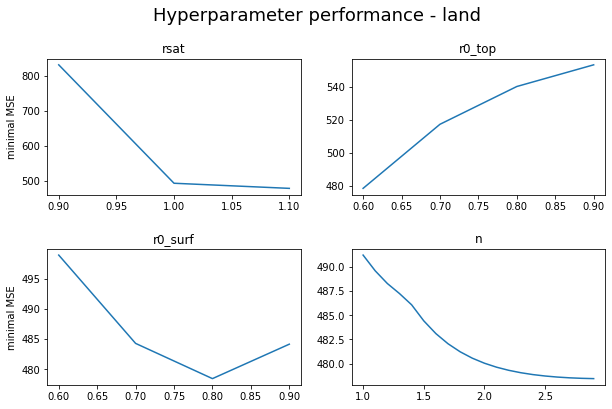

In [106]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Hyperparameter performance - land", fontsize=18, y=1)

hyp_par = ['rsat', 'r0_top', 'r0_surf', 'n']
hyp_par_range = [rsat_range_land, r0_top_range_land, r0_surf_range_land, n_range_land]

axes = (0,1,2,3)
for i, par in enumerate(hyp_par):
    # Add new subplot iteratively
    ax = plt.subplot(2, 2, i + 1)
    
    axis = axes[:i] + axes[(i+1):]
    ax.plot(hyp_par_range[i], np.min(mse_tensor_land, axis=axis))
    
    ax.set_title(par)
    if i in [0, 2]:
        ax.set_ylabel('minimal MSE')

plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/hyp_land_%d.pdf'%ran, \
            bbox_inches='tight')

In [107]:
mse_tensor_sea = np.load('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/mse_tensor_sea_%d.npy'%ran)

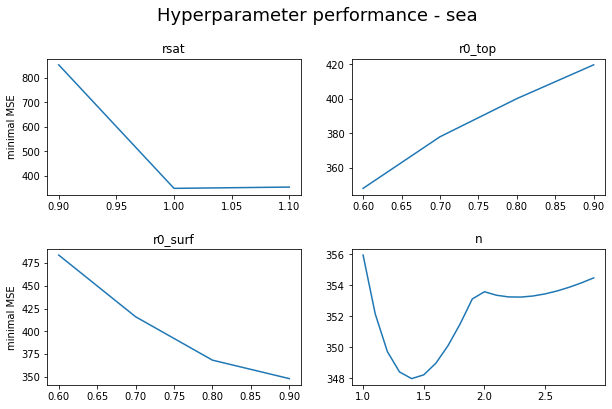

In [108]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Hyperparameter performance - sea", fontsize=18, y=1)

hyp_par = ['rsat', 'r0_top', 'r0_surf', 'n']
hyp_par_range = [rsat_range_sea, r0_top_range_sea, r0_surf_range_sea, n_range_sea]

axes = (0,1,2,3)
for i, par in enumerate(hyp_par):
    # Add new subplot iteratively
    ax = plt.subplot(2, 2, i + 1)
    
    axis = axes[:i] + axes[(i+1):]
    ax.plot(hyp_par_range[i], np.min(mse_tensor_sea, axis=axis))
    
    ax.set_title(par)
    if i in [0, 2]:
        ax.set_ylabel('minimal MSE')

plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/hyp_sea_%d.pdf'%ran, \
           bbox_inches='tight')

### Performance with the best hyperparameter setting (To run)

In [15]:
tuned='manually'

In [16]:
mse_train, r2_train = evaluate_sundqvist(flattened_input_train, flattened_output_train, loc, tuned)
mse_train_land, r2_train_land = evaluate_sundqvist(input_land, output_land, loc, tuned)
mse_train_sea, r2_train_sea = evaluate_sundqvist(input_sea, output_sea, loc, tuned)
mse_valid, r2_valid = evaluate_sundqvist(flattened_input_valid, flattened_output_valid, loc, tuned)

In [17]:
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/optimizing_manually/results.txt', 'a') as file:
    file.write('With tuned hyperparameters: %s\n'%tuned)
    file.write('Training score:\n')
    file.write('MSE: %.3f, R2: %.3f\n'%(mse_train, r2_train))
    file.write('Over land: \n')
    file.write('MSE: %.3f, R2: %.3f\n'%(mse_train_land, r2_train_land))
    file.write('Over sea:\n')
    file.write('MSE: %.3f, R2: %.3f\n'%(mse_train_sea, r2_train_sea))
    file.write('Validation score:\n')
    file.write('MSE: %.3f, R2: %.3f\n\n'%(mse_valid, r2_valid))